In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import requests
import pickle
import re
from sys import stdout

# Comics analysis

**In this notebook, we are only interested in the links created between characters that appear in the same comics. We will build an adjacency matrix based on that.**

# Part 1: Marvel dataset

In [2]:
with open('data/clean_marvel.txt', 'rb') as f:
    comics_marvel = pickle.load(f)

comics_marvel.drop(columns=['Relatives', "Affiliation"], inplace=True)

comics_marvel

,URL,Real Name,Current Alias,Subcomic URL,First appearance,Last appearance
0,/wiki/Aaron_Fox_(Earth-616),Aaron Fox,Unknown,[/wiki/Legion_of_Monsters_Vol_1_1Manphibian: V...,1975,1975
1,/wiki/Acrobat_(1940s)_(Earth-616),Unknown,Acrobat,[/wiki/Captain_America_Comics_Vol_1_64Death Is...,1947,1947
2,/wiki/Abigail_Mercury_(Clone)_(Earth-616),Abigail Mercury,Unknown,[/wiki/Ben_Reilly:_Scarlet_Spider_Vol_1_1st st...,2017,2017
3,/wiki/Ace_Maxwell_(Earth-616),Ace Maxwell,Unknown,[/wiki/Human_Torch_Comics_Vol_1_22The Fatal Fi...,1946,1946
4,/wiki/Abigail_Boylen_(Earth-616),"Abigail ""Abby"" Boylen",Cloud 9,[/wiki/Mighty_Avengers_Vol_1_1The Mighty Aveng...,2007,2019
...,...,...,...,...,...,...
26877,/wiki/Zzzyclone_(Warp_World)_(Earth-616),Zzzyclone,Unknown,[/wiki/Secret_Warps:_Soldier_Supreme_Annual_Vo...,2019,2019
26878,/wiki/Zuhn_(Earth-616),Zuhn,Chimera,[/wiki/Marvel:_The_Lost_Generation_Vol_1_4Ligh...,2000,2001
26879,/wiki/Zxaxz_(Earth-616),Zxaxz,Unknown,"[/wiki/Spellbound_Vol_2_2Nightmare!, /wiki/Spe...",1988,2010
26880,/wiki/Zuwena_(Earth-616),Zuwena,Unknown,[/wiki/Marvel_Universe_Magazine_Fall_Vol_1_1Th...,2018,2019


**We split the list in the column `Subcomic URL`, each URL that is in it will be in a different row, with the corresponding character.**

In [3]:
s = comics_marvel.apply(lambda x: pd.Series(x['Subcomic URL']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Subcomic URL'

comics_marvel = comics_marvel.drop('Subcomic URL', axis=1).join(s)
comics_marvel['Subcomic URL'] = pd.Series(comics_marvel['Subcomic URL'], dtype= 'b')
comics_marvel

,URL,Real Name,Current Alias,First appearance,Last appearance,Subcomic URL
0,/wiki/Aaron_Fox_(Earth-616),Aaron Fox,Unknown,1975,1975,/wiki/Legion_of_Monsters_Vol_1_1Manphibian: Ve...
1,/wiki/Acrobat_(1940s)_(Earth-616),Unknown,Acrobat,1947,1947,/wiki/Captain_America_Comics_Vol_1_64Death Is ...
2,/wiki/Abigail_Mercury_(Clone)_(Earth-616),Abigail Mercury,Unknown,2017,2017,/wiki/Ben_Reilly:_Scarlet_Spider_Vol_1_1st stor
2,/wiki/Abigail_Mercury_(Clone)_(Earth-616),Abigail Mercury,Unknown,2017,2017,/wiki/Ben_Reilly:_Scarlet_Spider_Vol_1_2st stor
3,/wiki/Ace_Maxwell_(Earth-616),Ace Maxwell,Unknown,1946,1946,/wiki/Human_Torch_Comics_Vol_1_22The Fatal Fif...
...,...,...,...,...,...,...
26880,/wiki/Zuwena_(Earth-616),Zuwena,Unknown,2018,2019,/wiki/Shuri_Vol_1_4Timbuktu
26880,/wiki/Zuwena_(Earth-616),Zuwena,Unknown,2018,2019,/wiki/Shuri_Vol_1_5The End of the Earth
26880,/wiki/Zuwena_(Earth-616),Zuwena,Unknown,2018,2019,/wiki/Shuri_Vol_1_824/7 Vibranium
26880,/wiki/Zuwena_(Earth-616),Zuwena,Unknown,2018,2019,/wiki/Shuri_TPB_Vol_1_224/7 Vibranium


**We create a list of unique urls, and use it as rows and columns of the adjacency matrix.**

In [4]:
urls = comics_marvel['URL'].unique()
adj_comics_marvel = pd.DataFrame(0, index=urls, columns=urls)

**We check that we don't have null value for `Subcomic URL`**

In [5]:
comics_marvel[comics_marvel['Subcomic URL'] ==""]

,URL,Real Name,Current Alias,First appearance,Last appearance,Subcomic URL


**We fill the diagonal of the adjacency matrix. The displayed value corresponds to the total number of appearitions the character has.**

In [6]:
i = 0
tot_comics = comics_marvel['URL'].unique().size

for url in comics_marvel['URL'].value_counts().index:
    # Loading bar
    i += 1
    printed= i/tot_comics*100
    stdout.write("\r%f %%" % printed)
    stdout.flush()
    adj_comics_marvel[url][url] += comics_marvel['URL'].value_counts()[url]

100.000000 %

In [7]:
comics_marvel['URL'].unique().size

26882

**For a given subcomic, we see all the corresponding characters. Then we do all the possible combinations between them to fill the adjacency matrix. The more a character (C1) has common subcomic with another (C2), the higher will be the cell adjacency[C1][C2] (and adjacency[C2][C1]).**

In [8]:
i = 0
tot_comics = comics_marvel['Subcomic URL'].unique().size

for a in comics_marvel['Subcomic URL'].unique():
    if a is not '':
        # Loading bar
        i += 1
        printed= i/tot_comics*100
        stdout.write("\r%f %%" % printed)
        stdout.flush()

        L = []
        L = ([a,comics_marvel[comics_marvel['Subcomic URL']==a]['URL'].values.tolist()])
        # All possible combinations
        for comb in list(itertools.combinations(L[1], 2)):
            adj_comics_marvel[comb[0]][comb[1]] += 1
            adj_comics_marvel[comb[1]][comb[0]] += 1

100.000000 %

In [9]:
adj_comics_marvel

,/wiki/Aaron_Fox_(Earth-616),/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Abigail_Mercury_(Clone)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/Abigail_Boylen_(Earth-616),/wiki/Abarac_(Earth-616),/wiki/Abner_Perry_(Earth-616),/wiki/Abdul_Qamar_(Earth-616),/wiki/Aaron_Verne_(Earth-616),/wiki/Abner_Doolittle_(Earth-616),...,/wiki/Zuras_(Earth-616),/wiki/Zreate%27th_(Earth-616),/wiki/Zyziwc_Tiel_(Earth-616),/wiki/Zuzha_Yu_(Earth-616),/wiki/Zula_(Earth-616),/wiki/Zzzyclone_(Warp_World)_(Earth-616),/wiki/Zuhn_(Earth-616),/wiki/Zxaxz_(Earth-616),/wiki/Zuwena_(Earth-616),/wiki/Zurvan_(Earth-616)
/wiki/Aaron_Fox_(Earth-616),1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Acrobat_(1940s)_(Earth-616),0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Mercury_(Clone)_(Earth-616),0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Boylen_(Earth-616),0,0,0,0,47,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zzzyclone_(Warp_World)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/wiki/Zuhn_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
/wiki/Zxaxz_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,0
/wiki/Zuwena_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0


In [10]:
pickle.dump(adj_comics_marvel, open("data/adj_comics_marvel.txt", 'wb'), protocol=4)

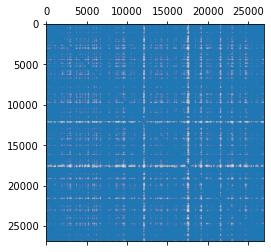

In [11]:
plt.spy(adj_comics_marvel,markersize=0.005)

In [12]:
#1950, 1990, Now
comics_marvel.reset_index(drop=True, inplace =True)
list_index_1950 = comics_marvel.loc[comics_marvel["First appearance"] < 1950, "URL"].unique().tolist()
list_index_1990 = comics_marvel.loc[comics_marvel["First appearance"] < 1990, "URL"].unique().tolist()

In [13]:
adj_comics_marvel_50 = adj_comics_marvel[adj_comics_marvel.index.isin(list_index_1950)]
adj_comics_marvel_50 = adj_comics_marvel_50.reindex(columns = list_index_1950, fill_value=0)
adj_comics_marvel_50

,/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/A.J._Raffles_(Earth-616),/wiki/Abraham_Erskine_(Earth-616),/wiki/Abra_and_Cadabra_(Earth-616),/wiki/Abner_Perkins_(Earth-616),/wiki/Ace_Turmbull_(Earth-616),/wiki/Aarkus_(Earth-616),/wiki/Ab_Waltin_(Earth-616),/wiki/Able_Doone_(Earth-616),...,/wiki/Zombo_(Earth-616),/wiki/Zerhu_(Earth-616),/wiki/Zombie_Master_(Earth-616),/wiki/Zephyrus_Jones_(Earth-616),/wiki/Zeb_Sanders_(Earth-616),/wiki/Zeke_Mallon_(Earth-616),/wiki/Zandow_(Earth-616),/wiki/Zipper_(1940%27s_Criminal)_(Earth-616),/wiki/Zomber_(Earth-616),/wiki/Zuras_(Earth-616)
/wiki/Acrobat_(1940s)_(Earth-616),1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/A.J._Raffles_(Earth-616),0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abraham_Erskine_(Earth-616),0,0,0,91,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abra_and_Cadabra_(Earth-616),0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zeke_Mallon_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/wiki/Zandow_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
/wiki/Zipper_(1940%27s_Criminal)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
/wiki/Zomber_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
pickle.dump(adj_comics_marvel_50, open("data/adj_comics_marvel_50.txt", 'wb'), protocol=4)

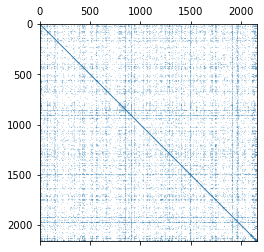

In [17]:
plt.spy(adj_comics_marvel_50,markersize=0.05)

In [18]:
adj_comics_marvel_90 = adj_comics_marvel[adj_comics_marvel.index.isin(list_index_1990)]
adj_comics_marvel_90 = adj_comics_marvel_90.reindex(columns = list_index_1990, fill_value=0)
adj_comics_marvel_90

,/wiki/Aaron_Fox_(Earth-616),/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/Abarac_(Earth-616),/wiki/Abner_Perry_(Earth-616),/wiki/Abdul_Qamar_(Earth-616),/wiki/Aaron_Verne_(Earth-616),/wiki/Abner_Doolittle_(Earth-616),/wiki/Abdul_Hurani_(Earth-616),/wiki/A3_(Earth-616),...,/wiki/Zsaji_(Earth-616),/wiki/Zuko_(Earth-616),/wiki/Zyro_(Earth-616),/wiki/Zukala_(Earth-616),/wiki/Zzutak_(Earth-616),/wiki/Zzzax_(Earth-616),/wiki/Zota_of_Pergamum_(Earth-616),/wiki/Zuras_(Earth-616),/wiki/Zula_(Earth-616),/wiki/Zxaxz_(Earth-616)
/wiki/Aaron_Fox_(Earth-616),1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Acrobat_(1940s)_(Earth-616),0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abarac_(Earth-616),0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abner_Perry_(Earth-616),0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zzzax_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,47,1,0,0,1
/wiki/Zota_of_Pergamum_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,5,0,0,1
/wiki/Zuras_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,81,0,0
/wiki/Zula_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,37,0


In [19]:
pickle.dump(adj_comics_marvel_90, open("data/adj_comics_marvel_90.txt", 'wb'), protocol=4)

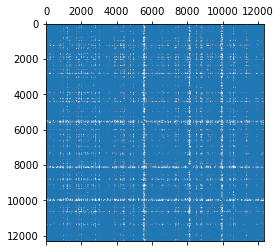

In [24]:
plt.spy(adj_comics_marvel_90,markersize=0.05)

# Part 2: DC dataset

In [25]:
with open('data/clean_dc.txt', 'rb') as f:
    comics_dc = pickle.load(f)

comics_dc.drop(columns=['Relatives', "Affiliation"], inplace=True)

comics_dc

,URL,Real Name,Current Alias,Subcomic URL,First appearance,Last appearance
0,/wiki/Aaron_Hayley_(New_Earth),Aaron Hayley,Swamp Thing,[/wiki/Swamp_Thing:_Rootshe 1st Stor],1998.0,1998.0
1,/wiki/Adam_Strange_(JSA:_The_Golden_Age),Adam Strange,Adam Strange,[/wiki/Golden_Age_Vol_1_4Book 4],1994.0,1994.0
2,/wiki/Alan_Barnes_(New_Earth),Alan Barnes,Brainstorm,[/wiki/S.T.A.R._Corps_Vol_1_6Shooting S.T.A.R....,1994.0,1994.0
3,/wiki/Alan_Scott_(Earth_2),Alan Scott,Green Lantern,[/wiki/Convergence:_Booster_Gold_Vol_1_2Diverg...,2012.0,2019.0
4,/wiki/Abigail_Arcane_(New_Earth),Abigail Arcane,Abigail Arcane,[/wiki/The_Best_of_DC_Vol_1_52Stopover in a Pl...,1973.0,2006.0
...,...,...,...,...,...,...
13184,/wiki/Zod_(Smallville),Zod,General Zod,[/wiki/Smallville_Season_11_Special_Vol_1_3Hol...,2013.0,2013.0
13185,/wiki/Zazzala_(Prime_Earth),Zazzala,Queen Bee,[/wiki/Wonder_Twins_Vol_1_4A Date Which Will L...,2019.0,2019.0
13186,/wiki/Zedabon_Zarr_(Earth-One),Zedabon Zarr,Breakaway Bandit,[/wiki/The_Flash_Vol_1_158Battle Against The B...,1966.0,1966.0
13187,/wiki/Zotan_(Earth-S),Zotan,Zotan,[/wiki/Marvel_Family_Vol_1_88The Marvel Family...,1953.0,1974.0


In [26]:
comics_dc[comics_dc["URL"].str.contains("/wiki/Abigail_Hunkel_(New_Earth)")]

/Users/antoineschmider/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,URL,Real Name,Current Alias,Subcomic URL,First appearance,Last appearance


**We split the list in the column `Subcomic URL`, each URL that is in it will be in a different row, with the corresponding character.**

In [27]:
s = comics_dc.apply(lambda x: pd.Series(x['Subcomic URL']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Subcomic URL'

comics_dc = comics_dc.drop('Subcomic URL', axis=1).join(s)
comics_dc['Subcomic URL'] = pd.Series(comics_dc['Subcomic URL'], dtype= 'b')
comics_dc

,URL,Real Name,Current Alias,First appearance,Last appearance,Subcomic URL
0,/wiki/Aaron_Hayley_(New_Earth),Aaron Hayley,Swamp Thing,1998.0,1998.0,/wiki/Swamp_Thing:_Rootshe 1st Stor
1,/wiki/Adam_Strange_(JSA:_The_Golden_Age),Adam Strange,Adam Strange,1994.0,1994.0,/wiki/Golden_Age_Vol_1_4Book 4
2,/wiki/Alan_Barnes_(New_Earth),Alan Barnes,Brainstorm,1994.0,1994.0,/wiki/S.T.A.R._Corps_Vol_1_6Shooting S.T.A.R.'s
2,/wiki/Alan_Barnes_(New_Earth),Alan Barnes,Brainstorm,1994.0,1994.0,/wiki/S.T.A.R._Corps_Vol_1_3S.T.A.R. Pupil
3,/wiki/Alan_Scott_(Earth_2),Alan Scott,Green Lantern,2012.0,2019.0,/wiki/Convergence:_Booster_Gold_Vol_1_2Diverge...
...,...,...,...,...,...,...
13186,/wiki/Zedabon_Zarr_(Earth-One),Zedabon Zarr,Breakaway Bandit,1966.0,1966.0,/wiki/The_Flash_Vol_1_158Battle Against The Br...
13187,/wiki/Zotan_(Earth-S),Zotan,Zotan,1953.0,1974.0,/wiki/Marvel_Family_Vol_1_88The Marvel Family ...
13187,/wiki/Zotan_(Earth-S),Zotan,Zotan,1953.0,1974.0,/wiki/Shazam!_Vol_1_15The Marvel Family Battle...
13188,/wiki/Zora_Vi-Lar_(Earth-One),Zora Vi-Lar,Black Flame,1963.0,1969.0,/wiki/Action_Comics_Vol_1_304The Maid of Menace!


In [28]:
comics_dc[comics_dc["URL"].str.contains("Abigail_Hunkel")]

,URL,Real Name,Current Alias,First appearance,Last appearance,Subcomic URL
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,/wiki/All-American_Comics_Vol_1_35The Rich Dam...
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,/wiki/All-American_Comics_Vol_1_50Scribbly Get...
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,"/wiki/All-American_Comics_Vol_1_4cribbly: ""Din..."
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,"/wiki/All-American_Comics_Vol_1_23cribbly: ""Af..."
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,"/wiki/All-American_Comics_Vol_1_36cribbly: ""Sq..."
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,"/wiki/All-American_Comics_Vol_1_3cribbly: ""Int..."
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,/wiki/All-American_Comics_Vol_1_48Ma Hunkel an...
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,/wiki/All-American_Comics_Vol_1_45Sheldon Maye...
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,/wiki/All-American_Comics_Vol_1_38Wanted for M...
5,/wiki/Abigail_Hunkel_(New_Earth),Abigail Mathilda Hunkel,Ma Hunkel,1.0,2015.0,/wiki/All-American_Comics_Vol_1_43The Sugar Ho...


**We create a list of unique urls, and use it as rows and columns of the adjacency matrix.**

In [29]:
urls = comics_dc['URL'].unique()
adj_comics_dc = pd.DataFrame(0, index=urls, columns=urls)

In [30]:
comics_dc[comics_dc['Subcomic URL'] ==""]

,URL,Real Name,Current Alias,First appearance,Last appearance,Subcomic URL


**We fill the diagonal of the adjacency matrix. The displayed value corresponds to the total number of subreddit the character appears in.**

In [31]:
i = 0
tot_comics = comics_dc['Subcomic URL'].unique().size

for url in comics_dc['URL'].value_counts().index:
    # Loading bar
    i += 1
    printed= i/tot_comics*100
    stdout.write("\r%f %%" % printed)
    stdout.flush()
    adj_comics_dc[url][url] += comics_dc['URL'].value_counts()[url]

40.950873 %

**As for Marvel, we see the corresponding characters to one subcomic and we fill in the adjacency.**

In [32]:
i = 0
tot_comics = comics_dc['Subcomic URL'].unique().size

for a in comics_dc['Subcomic URL'].unique():
    if a is not '':
        # Loading bar
        i += 1
        printed= i/tot_comics*100
        stdout.write("\r%f %%" % printed)
        stdout.flush()

        L = []
        L = ([a,comics_dc[comics_dc['Subcomic URL']==a]['URL'].values.tolist()])
        # All possible combinations
        for comb in list(itertools.combinations(L[1], 2)):
            adj_comics_dc[comb[0]][comb[1]] += 1
            adj_comics_dc[comb[1]][comb[0]] += 1

100.000000 %

In [33]:
adj_comics_dc

,/wiki/Aaron_Hayley_(New_Earth),/wiki/Adam_Strange_(JSA:_The_Golden_Age),/wiki/Alan_Barnes_(New_Earth),/wiki/Alan_Scott_(Earth_2),/wiki/Abigail_Arcane_(New_Earth),/wiki/Abigail_Hunkel_(New_Earth),/wiki/Abra-Ka-Dabra_(Tiny_Titans),/wiki/Adam_Strange_(The_Brave_and_the_Bold),/wiki/Adam_Strange_II_(Earth-One),/wiki/Agrippe_(New_Earth),...,/wiki/Z%C3%BCM_(New_Earth),/wiki/Zobar_Zodiak_(New_Earth),/wiki/Zephyr_(New_Earth),/wiki/Zwerg_(New_Earth),/wiki/Zera_Oliet_(Pre-Zero_Hour),/wiki/Zod_(Smallville),/wiki/Zazzala_(Prime_Earth),/wiki/Zedabon_Zarr_(Earth-One),/wiki/Zotan_(Earth-S),/wiki/Zora_Vi-Lar_(Earth-One)
/wiki/Aaron_Hayley_(New_Earth),1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Adam_Strange_(JSA:_The_Golden_Age),0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Alan_Barnes_(New_Earth),0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Alan_Scott_(Earth_2),0,0,0,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Arcane_(New_Earth),0,0,0,0,83,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zod_(Smallville),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/wiki/Zazzala_(Prime_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
/wiki/Zedabon_Zarr_(Earth-One),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
/wiki/Zotan_(Earth-S),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [34]:
pickle.dump(adj_comics_dc, open("data/adj_comics_dc.txt", 'wb'), protocol=4)

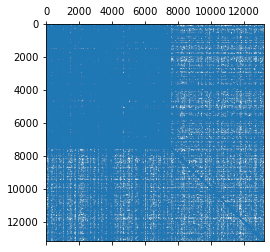

In [35]:
plt.spy(adj_comics_dc,markersize=0.05)

In [36]:
#1950, 1990, Now
comics_dc.reset_index(drop=True, inplace =True)
list_index_1950 = comics_dc.loc[comics_dc["First appearance"] < 1950, "URL"].unique().tolist()
list_index_1990 = comics_dc.loc[comics_dc["First apparition"] < 1990, "URL"].unique().tolist()

KeyError: 'First apparition'

In [ ]:
adj_comics_dc_50 = adj_comics_dc[adj_comics_dc.index.isin(list_index_1950)]
adj_comics_dc_50 = adj_comics_dc_50.reindex(columns = list_index_1950, fill_value=0)
adj_comics_dc_50

In [ ]:
pickle.dump(adj_comics_dc_50, open("data/adj_comics_dc_50.txt", 'wb'), protocol=4)

In [ ]:
plt.spy(adj_comics_dc_50,markersize=0.05)

In [ ]:
adj_comics_dc_90 = adj_comics_dc[adj_comics_dc.index.isin(list_index_1990)]
adj_comics_dc_90 = adj_comics_dc_90.reindex(columns = list_index_1990, fill_value=0)
adj_comics_dc_90

In [ ]:
pickle.dump(adj_comics_dc_90, open("data/adj_comics_dc_90.txt", 'wb'), protocol=4)

In [ ]:
plt.spy(adj_comics_dc_90,markersize=0.05)